In [42]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import beta 
import scipy.stats as st
import scipy.integrate as integrate
import pandas as pd
import time
import scipy

# Bayesian A/B testing vs Frequentist A/B testing

Bayesian and frequentist A/B testing offer different approaches to making decisions and interpreting experiment results. This notebook will simulate the results of a hypothetical experiment and discuss how the results would be processed differently in Bayesian and frequentist frameworks

**Step 1: Define the experiment**

Let's say that we have implemented a new feature on a health insurance website with the goal of helping users more easily sign up for coverage. We want to assess differences in conversion rate for our new website design versus our old design to help decide which version to run with in the future 

In [2]:
#define parameters for beta function
beta_a,beta_b=[1.1]*beta.numargs
rv=beta(beta_a,beta_b)

In [3]:
#produce an array with 100 values equally spaced between the 1% and 99% quantiles of the chosen Beta distribution
x=np.linspace(0,1,100)

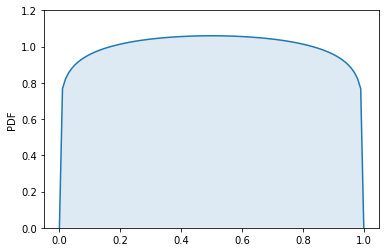

In [4]:
plt.figure()
plt.plot(x,rv.pdf(x))
plt.ylim(0,1.2)
plt.ylabel('PDF')
plt.fill_between(x,[0]*len(x),rv.pdf(x),alpha=.15)

In [5]:
#function to simulate conversion event

def simulate_conversion(base,effect_size,treatment):
    random_num=random.random()
    
    if treatment==True:
        if random_num<max(base+effect_size,0):
            return 1
        else:
            return 0
    else:
        if random_num<max(base,0):
            return 1
        else:
            return 0

In [6]:
def simulate_experiment(num_observations,base,effect_size,treatment):
    conversions=0
    for i in range(num_observations):
        conversions+=simulate_conversion(base,effect_size,treatment)
    return conversions

def simulate_experiments(num_experiments,num_observations,base,effect_size,treatment):
    exp_results=[0]*num_experiments
    for i in range(num_experiments):
        exp_results[i]=simulate_experiment(num_observations,base,effect_size,treatment)
    return exp_results

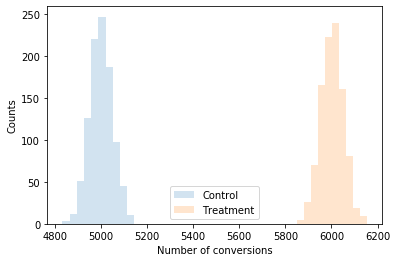

In [7]:
plt.figure()
treatment_effect=.1
base_effect=.5
plt.hist(simulate_experiments(1000,10000,base_effect,treatment_effect,False),label='Control',alpha=.2)
plt.hist(simulate_experiments(1000,10000,base_effect,treatment_effect,True),label='Treatment',alpha=.2)
plt.xlabel('Number of conversions')
plt.ylabel('Counts')
plt.legend()

In [8]:
class beta_distribution:
    def __init__ (self,beta_a=1,beta_b=1):
        self.beta_a=beta_a
        self.beta_b=beta_b
        self.rv=beta(beta_a,beta_b)
    
    def update_prior(self,base,effect_size,treatment):
        
        exp_result=simulate_conversion(base,effect_size,treatment)
        
        if exp_result==1:
            self.beta_a+=1
        else:
            self.beta_b+=1
        
        self.rv=beta(self.beta_a,self.beta_b)
        
        return exp_result
    
    def gen_pdf_array(self,X):
        return self.rv.pdf(X)

In [9]:
control_beta=beta_distribution(1,1)
variant_beta=beta_distribution(1,1)

In [10]:
num_trials=1000
for i in range(num_trials):
    control_beta.update_prior(base_effect,treatment_effect,False)
    variant_beta.update_prior(base_effect,treatment_effect,True)

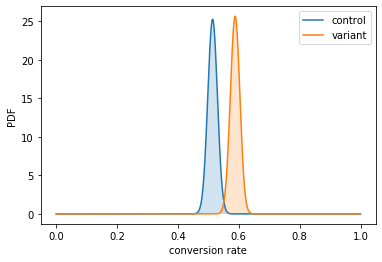

In [11]:
plt.figure()

x_vals=np.linspace(0,1,1000)
plt.plot(x_vals,control_beta.gen_pdf_array(x_vals),label='control')
plt.fill_between(x_vals,[0]*len(x_vals),control_beta.gen_pdf_array(x_vals),alpha=.2)
plt.plot(x_vals,variant_beta.gen_pdf_array(x_vals),label='variant')
plt.fill_between(x_vals,[0]*len(x_vals),variant_beta.gen_pdf_array(x_vals),alpha=.2)
plt.ylabel('PDF')
plt.xlabel('conversion rate')
plt.legend()

In [16]:

#This object is going to represent an A/B testing experiment conducted under a Bayesian framework

class Experiment:
    
    def __init__ (self,treatment_effect=0,base_effect=.5,tolerance=.005):
        
        self.base=beta_distribution(1,1) #our priors are going to be a beta dist to make posterior updating simple
        self.variant=beta_distribution(1,1)
        
        self.treatment_effect=treatment_effect #set the size of the effect of our treatment relative to the base effect
        self.base_effect=base_effect   #set base effect
        self.treatment_losses=[1] #this is going to get tabs of the expected losses for both A/B groups
        self.control_losses=[1]
        self.tolerance=tolerance #set the loss threshold needed to stop experiment
        self.num_steps=0 #keeps tracks of number of iterations of experiment
        self.base_events=[] #keeps track of conversion events for A/B groups
        self.treatment_events=[]
        
    def run_iteration(self):
        rand_val=random.random()
        if rand_val<.5:
            self.base.update_prior(self.base_effect,self.treatment_effect,False)
        else:
            self.variant.update_prior(self.base_effect,self.treatment_effect,True)
            
        self.compute_expected_loss()
        self.num_steps+=1

        return None
    
    def compute_base_average(self):
        if self.base_events==[]:
            return None
        else:
            return sum(self.base_events)/len(self.base_events)
        
    def compute_treatment_average(self):
        if self.treatment_events==[]:
            return None
        else:
            return sum(self.treatment_events)/len(self.treatment_events)
        
    def get_base_losses(self):
        return self.control_losses
    
    def get_treatment_losses(self):
        return self.treatment_losses
    
    def get_base_events(self):
        return self.base_events
    
    def get_treatment_events(self):
        return self.treatment_events
    
    def declare_winner(self,print_progress=False):
        
        while (self.treatment_losses[-1]>self.tolerance and self.control_losses[-1]>self.tolerance) and self.num_steps<300000:
            rand_val=random.random()
            
            if rand_val<.5:
                test_result=self.base.update_prior(self.base_effect,self.treatment_effect,False)
                self.base_events.append(test_result)
            else:
                test_result=self.variant.update_prior(self.base_effect,self.treatment_effect,True)
                self.treatment_events.append(test_result)
                
            if self.num_steps%1000==0:

                self.compute_expected_loss()
                
                if self.treatment_losses[-1]<self.tolerance:
                    return 1,self.num_steps
                
                elif self.control_losses[-1]<self.tolerance:
                    return 0,self.num_steps
                
                else:
                    if print_progress:
                        print('Step {} of experiment'.format(self.num_steps))
                        print('Treatment expected loss: {}'.format(self.treatment_losses[-1]))
                        print('Control expected loss: {}'.format(self.control_losses[-1]))
                    else:
                        pass


            self.num_steps+=1
            
        return 999,num_steps
            
    def plot_pdf(self):
        x_vals=np.linspace(0,1,1000)
        plt.plot(x_vals,self.base.gen_pdf_array(x_vals),label='control')
        plt.fill_between(x_vals,[0]*len(x_vals),self.base.gen_pdf_array(x_vals),alpha=.2)
        plt.plot(x_vals,self.variant.gen_pdf_array(x_vals),label='variant')
        plt.fill_between(x_vals,[0]*len(x_vals),self.variant.gen_pdf_array(x_vals),alpha=.2)
        plt.ylabel('PDF')
        plt.xlabel('conversion rate')
        plt.legend()
        plt.show()

    
    def compute_expected_loss(self):
        
        num_samples=10000

        randomA=[self.base.rv.rvs() for i in range(num_samples)]
        randomB=[self.variant.rv.rvs() for i in range(num_samples)]
        df=pd.DataFrame({'base':randomA,'variant':randomB})
        
        treatment_loss=np.sum(df[df['base']>df['variant']].apply(lambda x: x['base']-x['variant'],axis=1))/num_samples
        control_loss=np.sum(df[df['variant']>df['base']].apply(lambda x: x['variant']-x['base'],axis=1))/num_samples
        
        self.treatment_losses.append(treatment_loss)
        self.control_losses.append(control_loss)
        
        return None
        
        

In [17]:
conversion_experiment=Experiment(.1,.5)

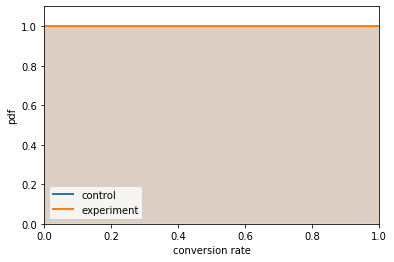

In [20]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1))
x_vals=np.linspace(0,1,1000)
ax.set_ylim(bottom=0,top=1.1)
ax.set_xlabel('conversion rate')
ax.set_ylabel('pdf')
control_beta=beta_distribution()
experiment_beta=beta_distribution()
control_dist, = ax.plot(x_vals, control_beta.gen_pdf_array(x_vals), lw=2,label='control')
fill_1=ax.fill_between(x_vals,[0]*len(x_vals),control_beta.gen_pdf_array(x_vals),alpha=.2,animated=True)
variant_dist, = ax.plot(x_vals, experiment_beta.gen_pdf_array(x_vals), lw=2,label='experiment')
fill_2=ax.fill_between(x_vals,[0]*len(x_vals),experiment_beta.gen_pdf_array(x_vals),alpha=.2,animated=True)
plt.legend()


from matplotlib import animation
from IPython.display import HTML
#initialization function: plot the background of each frame

def init():
    control_dist.set_data(x_vals, control_beta.gen_pdf_array(x_vals))
    variant_dist.set_data(x_vals, control_beta.gen_pdf_array(x_vals))
    return control_dist,variant_dist

#animation function.  This is called sequentially

def animate(i):
    
    for item in ax.collections:
        item.remove()
        
    sim_experiment.run_iteration()
    control_dist.set_data(x_vals, sim_experiment.base.gen_pdf_array(x_vals))
    variant_dist.set_data(x_vals, sim_experiment.variant.gen_pdf_array(x_vals))
    
    ax.fill_between(x_vals,[0]*len(x_vals),sim_experiment.base.gen_pdf_array(x_vals),alpha=.2,color='blue')
    ax.fill_between(x_vals,[0]*len(x_vals),sim_experiment.variant.gen_pdf_array(x_vals),alpha=.2,color='red')
    y_max=max([max(sim_experiment.base.gen_pdf_array(x_vals)),max(sim_experiment.variant.gen_pdf_array(x_vals))])
    ax.set_ylim(0,y_max)
    
    return control_dist,variant_dist

#call the animator.  blit=True means only re-draw the parts that have changed.
sim_experiment=Experiment(.25,.5)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=100, blit=True)

In [21]:
%matplotlib inline
HTML(anim.to_html5_video())

In [29]:
testExp=Experiment(.0004,.002,.00004)
start_time=time.time()
testExp.declare_winner(print_progress=True)
stop_time=time.time()

print('simulation run time: {} minutes'.format(round((stop_time-start_time)/60,2)))

Step 0 of experiment
Treatment expected loss: 0.08394620300192263
Control expected loss: 0.25202332756500456
Step 1000 of experiment
Treatment expected loss: 9.436740742792956e-05
Control expected loss: 0.007308363226217182
Step 2000 of experiment
Treatment expected loss: 0.0004351760373763744
Control expected loss: 0.0021057890205063773
Step 3000 of experiment
Treatment expected loss: 0.000308062096956323
Control expected loss: 0.0013997013072580458
Step 4000 of experiment
Treatment expected loss: 8.236508267211763e-05
Control expected loss: 0.001925000723424357
Step 5000 of experiment
Treatment expected loss: 0.00011650630752091513
Control expected loss: 0.001589143186161782
Step 6000 of experiment
Treatment expected loss: 0.00029763891355843054
Control expected loss: 0.0008343280462298688
Step 7000 of experiment
Treatment expected loss: 4.703823599618931e-05
Control expected loss: 0.001926081838685947
simulation run time: 0.18 minutes


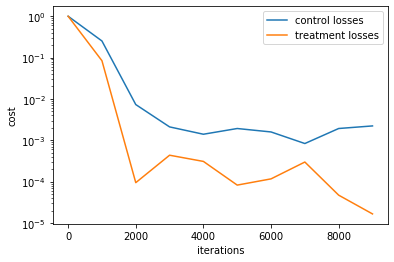

In [30]:
plt.figure()
plt.plot([1000*i for i in range(len(testExp.control_losses))],testExp.control_losses,label='control losses')
plt.plot([1000*i for i in range(len(testExp.control_losses))],testExp.treatment_losses,label='treatment losses')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.yscale('log')
plt.legend()

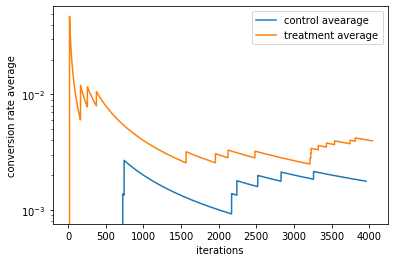

In [31]:
def moving_average(array,window_length=1):
    x=[array[0]]*len(array)
    loop_num=1
    for i,item in enumerate(x[1:]):
            x[i]=(x[i-1]+array[i+1])
    for i,item in enumerate(x):
        x[i]=x[i]/(i+1)
    return x[:-1]
    
base_ma=moving_average(testExp.base_events)
conversion_ma=moving_average(testExp.treatment_events)

plt.figure()
plt.plot([i for i in range(len(base_ma))],base_ma,label='control avearage')
plt.plot([i for i in range(len(conversion_ma))],conversion_ma,label='treatment average')
plt.xlabel('iterations')
plt.ylabel('conversion rate average')
plt.yscale('log')
plt.legend()

In [ ]:
#Now I want to run a series of simulations and get a sense of how often this test will pick the "right answer" and how
#long it takes

num_experiments=500
bayesian_test_results=[0]*num_experiments


try:
    del testExp
    
except:
    
    pass

for i in range(num_experiments):
    
    base_effect=.002
    treatment_effect=.0005
    convergence_criteria=.00004
    
    testExp=Experiment(treatment_effect,base_effect,convergence_criteria)
    test_results=testExp.declare_winner(print_progress=False)
    test_winner=test_results[0]
    test_num_steps=test_results[1]
    base_final_rate=testExp.compute_base_average()
    treatment_final_rate=testExp.compute_treatment_average()
    base_events=testExp.get_base_events()
    treatment_events=testExp.get_treatment_events()
    base_losses=testExp.get_base_losses()
    treatment_losses=testExp.get_treatment_losses()
    
    
    bayesian_test_results[i]=[test_winner,test_num_steps,treatment_final_rate, \
                              base_final_rate,treatment_events,base_events,treatment_losses,base_losses]
    
    del testExp
    
    print('Iteration {} complete'.format(i))
    

Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete
Iteration 10 complete
Iteration 11 complete
Iteration 12 complete
Iteration 13 complete
Iteration 14 complete
Iteration 15 complete
Iteration 16 complete
Iteration 17 complete
Iteration 18 complete
Iteration 19 complete
Iteration 20 complete
Iteration 21 complete
Iteration 22 complete
Iteration 23 complete
Iteration 24 complete
Iteration 25 complete
Iteration 26 complete
Iteration 27 complete
Iteration 28 complete
Iteration 29 complete
Iteration 30 complete
Iteration 31 complete
Iteration 32 complete
Iteration 33 complete
Iteration 34 complete
Iteration 35 complete
Iteration 36 complete
Iteration 37 complete
Iteration 38 complete
Iteration 39 complete
Iteration 40 complete
Iteration 41 complete
Iteration 42 complete
Iteration 43 complete
Iteration 44 complete
Iteration 45 complet

In [ ]:
print('treatment group win rate: {}'.format(np.mean([i[0] for i in bayesian_test_results])))
print('Average number of iterations per experiment: {}'.format(np.mean([i[1] for i in bayesian_test_results])))

In [ ]:
bay_df=pd.DataFrame(bayesian_test_results)
bay_df.columns=['exp. winner','sample size','final treatment rate','final base rate',\
                'treatment events','base events','treatment losses','base losses']
bay_df.to_pickle('bayesian_results.pkl')

In [ ]:
plt.figure()
plt.hist([i[1] for i in bayesian_test_results],bins=20,alpha=.5)
plt.xlabel('number of steps to complete experiment')
plt.ylabel('count')

In [128]:
class A_B_Experiment():
    
    def __init__ (self,treatment_effect,base_effect,min_effect_size,alpha=.95,power=.8):
        self.treatment_effect=treatment_effect
        self.base_effect=base_effect
        self.min_effect_size=min_effect_size
        self.alpha=alpha
        self.power=power
        self.treatment_results=[]
        self.base_results=[]
        self.numSamples=self.calculate_sample_size()*2
        
    def get_treatment_effect(self):
        return self.treatment_effect
    
        
    def get_base_effect(self):
        return self.base_effect
    
    
    def calculate_base_rate(self):
        return np.mean(self.base_results)
    
    def calculate_treatment_rate(self):
        return np.mean(self.treatment_results)

    def get_alpha(self):
        return self.alpha
    
    def get_min_effect_size(self):
        return self.min_effect_size
    
    def get_power(self):
        return self.power
    
    
    def get_sample_size(self):
        return self.numSamples
    
    def calculate_sample_size(self):
        
        Z_alpha=np.abs(st.norm.ppf((1-self.get_alpha())/2))
        Z_beta=np.abs(st.norm.ppf(1-self.get_power()))
        
        base_rate=self.get_base_effect()
        min_effect_size=self.get_min_effect_size()
        
        sample_size=(Z_alpha+Z_beta)**2*((2*base_rate+min_effect_size)*(1-(2*base_rate+min_effect_size)/2))\
                                         /(min_effect_size)**2
        
                                         
        return int(sample_size)
    
    def run_exp(self):
        
        num_steps=0
        sample_size=self.get_sample_size()
        while num_steps<sample_size:
            
            rand_treatment_group=random.random()
            rand_a=random.random()
            rand_b=random.random()
        
            if rand_treatment_group<0.5:
                
                if rand_a<self.get_base_effect():
                    self.base_results.append(1)
                else:
                    self.base_results.append(0)

            else:
                
                if rand_b<(self.get_base_effect()+self.get_treatment_effect()):

                    self.treatment_results.append(1)
                else:
                    self.treatment_results.append(0)

            num_steps+=1
        
        return None
    
    def declare_winner(self):
        
        self.run_exp()
        base_cr=self.calculate_base_rate()
        treatment_cr=self.calculate_treatment_rate()
        effect_mag=treatment_cr-base_cr
        std_error=((base_cr*(1-base_cr)/len(self.base_results))+ \
        (treatment_cr*(1-treatment_cr)/len(self.treatment_results)))**.5
        
        eff_z_score=scipy.stats.norm.sf(abs(effect_mag/std_error))*2
        
        if eff_z_score< 1-self.get_alpha():
            
            return 1
        else:
            return 0
    
    

In [131]:
freq_results=[0]*num_experiments

for i in range(num_experiments): 
    testExp=A_B_Experiment(treatment_effect,base_effect,treatment_effect,.95,.8)
    exp_winner=testExp.declare_winner()
    freq_results[i]=[exp_winner, testExp.get_sample_size(),testExp.calculate_treatment_rate(),testExp.calculate_base_rate(),testExp.treatment_results,testExp.base_results]
    
    del testExp
    

simulated power: 0.796


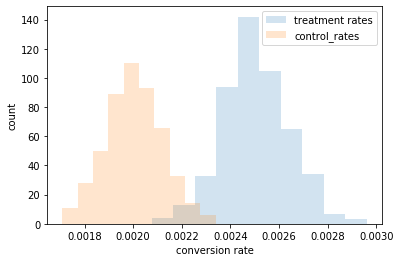

In [132]:
print('simulated power: {}'.format(np.mean([i[0] for i in freq_results])))
plt.figure()
plt.hist([i[2] for i in freq_results],label='treatment rates',alpha=.2)
plt.hist([i[3] for i in freq_results],label='control_rates',alpha=.2)
plt.xlabel('conversion rate')
plt.ylabel('count')
plt.legend()

In [146]:
freq_df=pd.DataFrame(freq_results)
freq_df.columns=['exp. winner','sample size','final treatment rate','final base rate','treatment events','base events']
freq_df.to_pickle('frequentist_results.pkl')